In [1]:
import numpy as np
import matplotlib.pyplot as plt
import mujoco
import mediapy as media

from lib.multiSegmentActuator import *
from lib.Actuator import *
from lib.optimization import *

In [2]:
target = resampleUniform(CurveGenerator(nCtrl= 3, order = 2, nPoints=500), 500)
target /= np.linalg.norm(target[1:] - target[:-1], axis=-1).sum()

In [3]:
config = {'file': 'softActuator.xml',
          'mass': 0.1,
          'length': 0.3,
          'radius': 0.025,
          'numDisks': 16,
          'numSegments': 3,
          'fillRatio': 0.5,
          'innerStiffness': 0,
          'innerDamping': 1.0e5,
          'outerStiffness': 1.0e6,
          'outerDamping': 0.0,
          'gear': 1.0e5,
          'timeStep': 0.01,
          'camPosition': [0.15, 0.0, 2],
          'camOrientation': [0.0, 0.0, 0.0]}

""

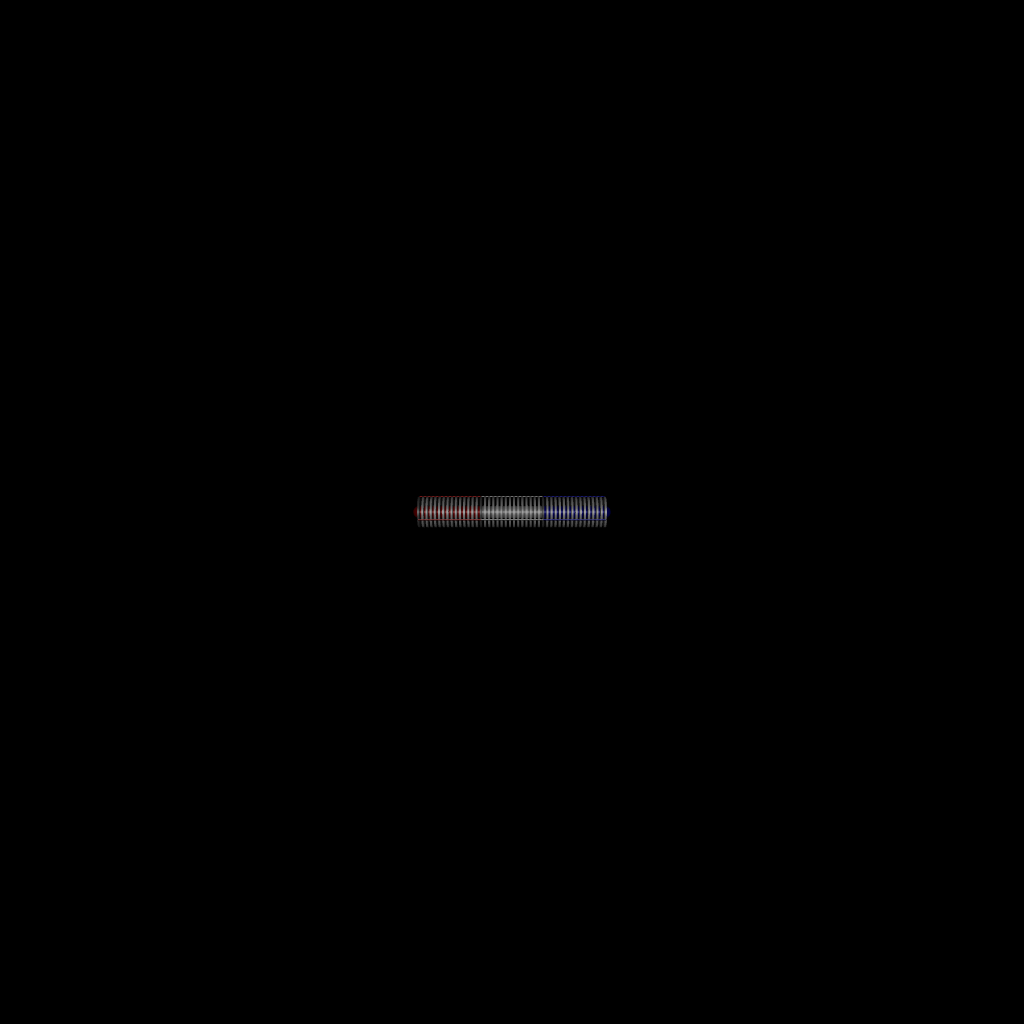

In [4]:
generateXML(config)
actuator3 = softActuator(config)
height = width = 1024
with mujoco.Renderer(actuator3.model, height, width) as renderer:
    renderer.update_scene(actuator3.data, camera='mainCamera')
    imRef = renderer.render()
media.show_image(imRef)

KMeans breaks: [  0 136 222 499]
MeanShift breaks: [  0 159 212 499]
DBSCAN breaks: [  0 145 249 499]
Break indices: [  0 159 212 499]
Break points (target curve, x y z):
  0: [0. 0. 0.]
  1: [ 0.31235087 -0.00385198  0.04746379]
  2: [ 0.36705023 -0.0106305   0.13098812]
  3: [-0.03257242 -0.04272532  0.5264576 ]
Arc lengths of each segment:
  0: 0.318638
  1: 0.106210
  2: 0.575151

Segment 0:
  Arc length: 0.318218
  Beta: 0.413113
  Alpha: 0.004306

Segment 1:
  Arc length: 0.106329
  Beta: 1.199233
  Alpha: 6.249101

Segment 2:
  Arc length: 0.570892
  Beta: 0.572101
  Alpha: 3.286612

Initial params [l, beta, alpha] for each segment (ready for optimizer):
[[3.18217993e-01 4.13112640e-01 4.30631638e-03]
 [1.06329426e-01 1.19923306e+00 6.24910069e+00]
 [5.70891798e-01 5.72101474e-01 3.28661156e+00]]


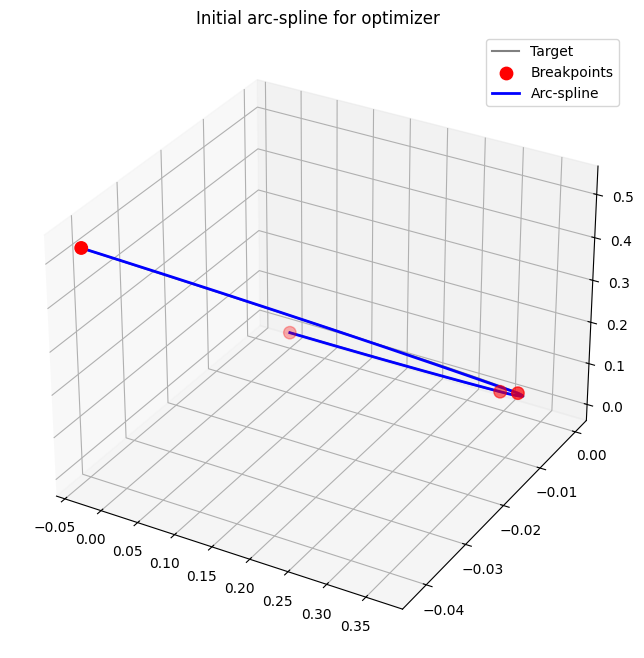

In [9]:
import numpy as np
import matplotlib.pyplot as plt

# --- Utility functions ---
def CurveGenerator(nCtrl=3, order=2, nPoints=500):
    from scipy.interpolate import BSpline
    np.random.seed(42)
    ctrl = 2 * np.random.rand(nCtrl, 3) - 1
    ctrl[0] = [0, 0, 0]
    ctrl[1] = [1, 0, 0]
    interior = np.arange(1, nCtrl - order) / (nCtrl - order)
    knots = np.concatenate((np.zeros(order+1), interior, np.ones(order+1)))
    bSpline = BSpline(knots, ctrl, order)
    u = np.linspace(0, 1, nPoints)
    return bSpline(u)

def resampleUniform(points, nSamples=None):
    diffs = points[1:] - points[:-1]
    dists = np.linalg.norm(diffs, axis=1)
    s = np.concatenate(([0], np.cumsum(dists)))
    if nSamples is None:
        nSamples = len(points)
    s_uniform = np.linspace(0, s[-1], nSamples)
    x_u = np.interp(s_uniform, s, points[:,0])
    y_u = np.interp(s_uniform, s, points[:,1])
    z_u = np.interp(s_uniform, s, points[:,2])
    return np.stack([x_u, y_u, z_u], axis=-1)

from scipy.signal import find_peaks, savgol_filter

def estimate_curvature_3d(points, window=9):
    """Estimate pointwise curvature for a 3D discrete curve (returns same length as points)."""
    x, y, z = points[:,0], points[:,1], points[:,2]
    # Smooth derivatives for robustness
    x1 = savgol_filter(x, window, 2, deriv=1)
    y1 = savgol_filter(y, window, 2, deriv=1)
    z1 = savgol_filter(z, window, 2, deriv=1)
    x2 = savgol_filter(x, window, 2, deriv=2)
    y2 = savgol_filter(y, window, 2, deriv=2)
    z2 = savgol_filter(z, window, 2, deriv=2)
    num = np.linalg.norm(np.cross(np.stack([x1, y1, z1], axis=1),
                                  np.stack([x2, y2, z2], axis=1)), axis=1)
    denom = (x1**2 + y1**2 + z1**2)**1.5 + 1e-8
    curvature = num / denom
    # Optional: smooth again for stable partitioning
    curvature = savgol_filter(curvature, window, 2)
    return curvature

from sklearn.cluster import KMeans, MeanShift, DBSCAN
from scipy.signal import find_peaks, savgol_filter
from sklearn.cluster import KMeans, MeanShift, DBSCAN

def enforce_num_segments(breaks, n, n_segments, min_seg):
    """
    Ensure breaks are strictly increasing, in [0, n-1], and there are exactly n_segments+1 breakpoints.
    If too few, fill in missing with uniform splitting.
    If too many, merge shortest segments until n_segments is reached.
    """
    breaks = np.array(sorted(set(breaks)))
    # Remove too-close breaks due to min_seg
    good_breaks = [breaks[0]]
    for b in breaks[1:]:
        if b - good_breaks[-1] >= min_seg:
            good_breaks.append(b)
    if good_breaks[-1] != n-1:
        good_breaks.append(n-1)
    breaks = np.array(good_breaks)
    # If too few breaks, fill with uniform
    while len(breaks) < n_segments + 1:
        # Insert midpoints where largest gap exists
        gaps = np.diff(breaks)
        idx = np.argmax(gaps)
        new_break = (breaks[idx] + breaks[idx+1]) // 2
        breaks = np.sort(np.append(breaks, new_break))
    # If too many breaks, merge closest
    while len(breaks) > n_segments + 1:
        gaps = np.diff(breaks)
        idx = np.argmin(gaps)
        # Remove the right break of closest pair
        breaks = np.delete(breaks, idx+1)
    return breaks

def multi_clustering_partition(curve, n_segments, min_seg=30, max_seg=200,
                               curvature_window=9, bandwidth=None, dbscan_eps=0.3):
    """
    Partition using KMeans, MeanShift, and DBSCAN on curvature profile.
    Returns a dict: {'kmeans': ..., 'meanshift': ..., 'dbscan': ...}
    Each value is a numpy array of break indices, with exactly n_segments+1 entries.
    """
    from sklearn.cluster import KMeans, MeanShift, DBSCAN

    curvature = estimate_curvature_3d(curve, window=curvature_window)
    n = len(curve)
    x = np.arange(n).reshape(-1,1)
    features = np.hstack([x / n, curvature.reshape(-1,1)]) # scaled position + curvature

    partitions = {}

    # --- KMeans clustering ---
    kmeans = KMeans(n_clusters=n_segments, random_state=42)
    km_labels = kmeans.fit_predict(features)
    km_breaks = [0]
    for i in range(1, n):
        if km_labels[i] != km_labels[i-1]:
            km_breaks.append(i)
    if km_breaks[-1] != n-1:
        km_breaks.append(n-1)
    km_breaks = enforce_num_segments(km_breaks, n, n_segments, min_seg)
    partitions['kmeans'] = km_breaks

    # --- MeanShift clustering ---
    ms = MeanShift(bandwidth=bandwidth)
    ms_labels = ms.fit_predict(features)
    ms_breaks = [0]
    for i in range(1, n):
        if ms_labels[i] != ms_labels[i-1]:
            ms_breaks.append(i)
    if ms_breaks[-1] != n-1:
        ms_breaks.append(n-1)
    ms_breaks = enforce_num_segments(ms_breaks, n, n_segments, min_seg)
    partitions['meanshift'] = ms_breaks

    # --- DBSCAN clustering ---
    db = DBSCAN(eps=dbscan_eps, min_samples=min_seg)
    db_labels = db.fit_predict(features)
    db_breaks = [0]
    for i in range(1, n):
        if db_labels[i] != db_labels[i-1]:
            db_breaks.append(i)
    if db_breaks[-1] != n-1:
        db_breaks.append(n-1)
    db_breaks = enforce_num_segments(db_breaks, n, n_segments, min_seg)
    partitions['dbscan'] = db_breaks

    return partitions

def arc_from_three_points(p0, pm, p1, n_points=100):
    v1 = pm - p0
    v2 = p1 - p0
    plane_normal = np.cross(v1, v2)
    norm_plane = np.linalg.norm(plane_normal)
    if norm_plane < 1e-8:
        pts = np.linspace(p0, p1, n_points)
        return pts, np.linalg.norm(p1 - p0), 0.0
    plane_normal /= norm_plane
    e1 = (p1 - p0)
    e1 /= np.linalg.norm(e1)
    e2 = np.cross(plane_normal, e1)
    def to_plane(P):
        rel = P - p0
        return np.array([np.dot(rel, e1), np.dot(rel, e2)])
    def from_plane(xy):
        return p0 + xy[0]*e1 + xy[1]*e2
    p0p, pmp, p1p = to_plane(p0), to_plane(pm), to_plane(p1)
    def circle_center(p, q, r):
        temp = q - p
        temp1 = r - q
        denom = 2*(temp[0]*temp1[1] - temp[1]*temp1[0])
        if np.abs(denom) < 1e-12:
            return (p + r)/2, np.inf
        a = np.dot(q, q) - np.dot(p, p)
        b = np.dot(r, r) - np.dot(q, q)
        cx = (a*temp1[1] - b*temp[1]) / denom
        cy = (b*temp[0] - a*temp1[0]) / denom
        center = np.array([cx, cy])
        radius = np.linalg.norm(p - center)
        return center, radius
    center, R = circle_center(p0p, pmp, p1p)
    if np.isinf(R):
        pts = np.linspace(p0, p1, n_points)
        return pts, np.linalg.norm(p1 - p0), 0.0
    def angle(x):
        return np.arctan2(x[1]-center[1], x[0]-center[0])
    ang0 = angle(p0p)
    ang1 = angle(p1p)
    angm = angle(pmp)
    if (ang0 < angm < ang1) or (ang1 < angm < ang0):
        ts = np.linspace(ang0, ang1, n_points)
    else:
        ts = np.linspace(ang0, ang1 - 2*np.pi*np.sign(ang1-ang0), n_points)
    pts2d = np.array([center[0] + R*np.cos(ts), center[1] + R*np.sin(ts)]).T
    arc_3d = np.array([from_plane(pt) for pt in pts2d])
    arc_length = R * np.abs(ts[-1] - ts[0])
    beta = ts[-1] - ts[0]
    return arc_3d, arc_length, beta

# --- Config ---

num_segments = config['numSegments']


min_seg = 30      # Minimum number of points per segment (adjust as needed)
max_seg = 250     # Maximum number of points per segment (adjust as needed)

partitions = multi_clustering_partition(target, n_segments=3, min_seg=30, max_seg=200)
print("KMeans breaks:", partitions['kmeans'])
print("MeanShift breaks:", partitions['meanshift'])
print("DBSCAN breaks:", partitions['dbscan'])

# Use any method in your later code:

# --- New: Get breakpoints with all clusterings


# Now you can use, for example:
break_indices = partitions['meanshift']     # or 'meanshift', or 'dbscan' or "kmeans"
breakpoints = target[break_indices]


#breakpoints = target[break_indices]
cum_s = np.cumsum(np.linalg.norm(target[1:] - target[:-1], axis=1))
cum_s = np.insert(cum_s, 0, 0.0)

print("Break indices:", break_indices)
print("Break points (target curve, x y z):")
for i, bp in enumerate(breakpoints):
    print(f"  {i}: {bp}")
print("Arc lengths of each segment:")
for i in range(num_segments):
    idx_start, idx_end = break_indices[i], break_indices[i+1]
    seg_arc_len = cum_s[idx_end] - cum_s[idx_start]
    print(f"  {i}: {seg_arc_len:.6f}")

# --- 3. Compute initial arc params ---
params_init = []
arc_spline = []
for i in range(num_segments):
    idx_start, idx_end = break_indices[i], break_indices[i+1]
    p0, p1 = target[idx_start], target[idx_end]
    seg = target[idx_start:idx_end+1]
    seg_s = np.cumsum(np.linalg.norm(seg[1:] - seg[:-1], axis=1))
    seg_s = np.insert(seg_s, 0, 0.0)
    s_half = seg_s[-1] / 2
    mid_idx = np.searchsorted(seg_s, s_half)
    pmid = seg[mid_idx]
    arc, arc_len, beta = arc_from_three_points(p0, pmid, p1, n_points=100)
    arc_spline.append(arc)
    tangent = arc[1] - arc[0] if np.linalg.norm(arc[1] - arc[0]) >= 1e-12 else arc[-1] - arc[0]
    alpha = np.arctan2(tangent[1], tangent[0])
    alpha = (alpha + 2*np.pi) % (2*np.pi)
    params_init.append([arc_len, beta, alpha])
    print(f"\nSegment {i}:")
    print(f"  Arc length: {arc_len:.6f}")
    print(f"  Beta: {beta:.6f}")
    print(f"  Alpha: {alpha:.6f}")

params_init = np.array(params_init)
print("\nInitial params [l, beta, alpha] for each segment (ready for optimizer):")
print(params_init)

arc_spline = np.vstack(arc_spline)

# --- 4. Visualize ---
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.plot(target[:,0], target[:,1], target[:,2], color='gray', label='Target')
ax.scatter(breakpoints[:,0], breakpoints[:,1], breakpoints[:,2], color='red', s=80, label='Breakpoints', zorder=10)
ax.plot(arc_spline[:,0], arc_spline[:,1], arc_spline[:,2], color='blue', lw=2, label='Arc-spline')
ax.legend()
ax.set_title('Initial arc-spline for optimizer')
plt.show()

# --- params_init is now ready for your optimizer ---


In [10]:
def map_physical_to_unconstrained(params, lower, upper):
    rng = (upper - lower)
    x = 2 * (params - (upper + lower) / 2) / rng
    x = np.clip(x, -1+1e-7, 1-1e-7)
    return np.arctanh(x)

# Suppose params_init is (N,3) array from analytic/heuristic init
params_init_physical = np.array(params_init)
lower = np.array(actuator3.lowerBound)
upper = np.array(actuator3.upperBound)
params_init_unconstrained = map_physical_to_unconstrained(params_init_physical, lower, upper)

optim = arcSplineOptimizer(actuator3, 1e-1, 0.995)
optim.params = jnp.array(params_init_unconstrained)
optim.optState = optim.optimizer.init(optim.params)
params, desired, loss = optim.optimize(target, 20000, 1000)


Iteration 1000: Loss = 0.000926083128
Iteration 2000: Loss = 0.000922463427
Iteration 3000: Loss = 0.000918370439
Iteration 4000: Loss = 0.000911496812
Iteration 5000: Loss = 0.000900219311
Iteration 6000: Loss = 0.000882156543
Iteration 7000: Loss = 0.000855057151
Iteration 8000: Loss = 0.000819418114
Iteration 9000: Loss = 0.000780224218
Iteration 10000: Loss = 0.000744891993
Iteration 11000: Loss = 0.000719092670
Iteration 12000: Loss = 0.000702664023
Iteration 13000: Loss = 0.000691037916
Iteration 14000: Loss = 0.000680454890
Iteration 15000: Loss = 0.000671381888
Iteration 16000: Loss = 0.000664378982
Iteration 17000: Loss = 0.000659115729
Iteration 18000: Loss = 0.000655145443
Iteration 19000: Loss = 0.000652104733
Iteration 20000: Loss = 0.000649694004


In [5]:
optim = arcSplineOptimizer(actuator3, 1e-1, 0.995)
params, desired, loss = optim.optimize(target, 20000, 1000)

Iteration 1000: Loss = 0.001968166558
Iteration 2000: Loss = 0.001930206199
Iteration 3000: Loss = 0.001890616026
Iteration 4000: Loss = 0.001831362140
Iteration 5000: Loss = 0.001750155701
Iteration 6000: Loss = 0.001649190322
Iteration 7000: Loss = 0.001536195399
Iteration 8000: Loss = 0.001421406982
Iteration 9000: Loss = 0.001312266337
Iteration 10000: Loss = 0.001210970222
Iteration 11000: Loss = 0.001117262407
Iteration 12000: Loss = 0.001032392262
Iteration 13000: Loss = 0.000958924065
Iteration 14000: Loss = 0.000898813247
Iteration 15000: Loss = 0.000851811841
Iteration 16000: Loss = 0.000815084437
Iteration 17000: Loss = 0.000785567681
Iteration 18000: Loss = 0.000761386647
Iteration 19000: Loss = 0.000741384400
Iteration 20000: Loss = 0.000724752666


In [11]:
duration = 10 # (seconds)
framerate = 30  # (fps)

act = 1

# Simulate and display video.
frames = []
ii = 0
T = 5
actuator3.reset()
actuator3.setStiffness(params, act)
ctrl = np.zeros(3)
with mujoco.Renderer(actuator3.model, height, width) as renderer:
    while np.round(actuator3.data.time, 1-int(np.log10(0.01))) <= duration:
        ctrl = min((ii+1) / T, 1) * act
        actuator3.step(ctrl)
        if len(frames) < actuator3.data.time * framerate:
            renderer.update_scene(actuator3.data, camera='mainCamera')
            frame = renderer.render()
            frames.append(frame)
        ii += 1
actual = actuator3.data.site_xpos.reshape(-1, 4, 3)[:, 0, :]

In [7]:
media.show_video(frames, fps=framerate)

In [7]:
def set_axes_equal(ax):
    """
    Make x, y, z axes of a 3-D plot have the same scale
    so a unit cube looks like a cube.
    """
    # current limits
    xlim = ax.get_xlim3d()
    ylim = ax.get_ylim3d()
    zlim = ax.get_zlim3d()

    rng   = np.array([xlim, ylim, zlim])
    mids  = rng.mean(axis=1)
    radius = 0.5 * np.max(rng[:,1] - rng[:,0])

    ax.set_xlim3d(mids[0] - radius, mids[0] + radius)
    ax.set_ylim3d(mids[1] - radius, mids[1] + radius)
    ax.set_zlim3d(mids[2] - radius, mids[2] + radius)

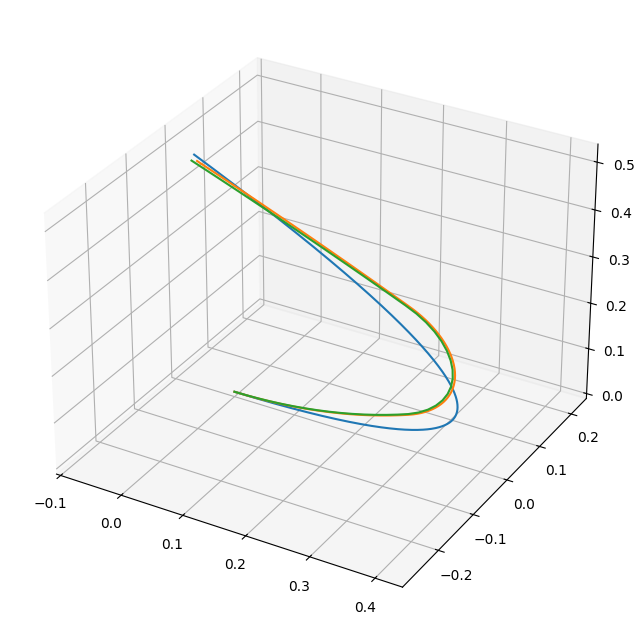

In [12]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
ax.plot(target[:,0], target[:,1], target[:,2])
ax.plot(desired[:,0], desired[:,1], desired[:,2])
ax.plot(actual[:,0], actual[:,1], actual[:,2])
set_axes_equal(ax)
plt.show()